In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
from sklearn.exceptions import ConvergenceWarning
from sklearn import model_selection, preprocessing, metrics
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNetCV, LassoLarsCV, OrthogonalMatchingPursuitCV
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.utils import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint
import time
import xgboost as xgb
import csv
import pickle
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [7]:
RAW_DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/raw_data'
DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data'
TRAIN_DATA = os.path.join(RAW_DATA_PATH, 'train.csv')
TEST_DATA = os.path.join(RAW_DATA_PATH, 'test.csv')
SAMPLE_SUBMISSION = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')
MODELS_PATH = os.path.join(DATA_PATH, 'models')

In [8]:
train_df = pd.read_csv(TRAIN_DATA)
test_df = pd.read_csv(TEST_DATA)
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION)
print('train_df.shape', train_df.shape)
print('test_df.shape', test_df.shape)

train_df.shape (4209, 378)
test_df.shape (4209, 377)


In [9]:
filter_outliers = True
xgb_use_augment_features = True
add_magic_feature = True

if filter_outliers:
    print('Filtering outliers')
    # Filter out outlier y = 265.32
    train_df = train_df[train_df.y < 200]

# Preprocess data
for column in train_df.columns:
    cardinality = len(np.unique(train_df[column]))
    if cardinality == 1:
        train_df.drop(column, axis=1, inplace=True)
        test_df.drop(column, axis=1, inplace=True)

original_train_columns = sorted(list(set(train_df.columns) - set(['ID', 'y'])))
        
for f in ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
    lbl = preprocessing.LabelEncoder()
    train_values = set(train_df[f].values)
    test_values = set(test_df[f].values)
    all_values = list(train_values | test_values)
    lbl.fit(all_values) 
    train_df[f] = lbl.transform(list(train_df[f].values))
    test_df[f] = lbl.transform(list(test_df[f].values))
    
if xgb_use_augment_features:
    n_comp = 10
    
    # PCA
    pca = PCA(n_components=n_comp, random_state=420)
    pca2_results_train = pca.fit_transform(train_df.drop(["y"], axis=1))
    pca2_results_test = pca.transform(test_df)

    # ICA
    ica = FastICA(n_components=n_comp, random_state=420)
    ica2_results_train = ica.fit_transform(train_df.drop(["y"], axis=1))
    ica2_results_test = ica.transform(test_df)

    # Append decomposition components to datasets
    for i in range(0, n_comp):
        train_df['pca_' + str(i)] = pca2_results_train[:, i]
        test_df['pca_' + str(i)] = pca2_results_test[:, i]

        train_df['ica_' + str(i)] = ica2_results_train[:, i]
        test_df['ica_' + str(i)] = ica2_results_test[:, i]

print('train_df.shape', train_df.shape)
print('test_df.shape', test_df.shape)

Filtering outliers
train_df.shape (4208, 386)
test_df.shape (4209, 385)


In [10]:
X = train_df.drop(["ID", "y"], axis=1)
Y = train_df['y'].values
test_X = test_df.drop(["ID"], axis=1)

train_X, holdout_X, train_Y, holdout_Y = model_selection.train_test_split(X, Y, test_size=0.2, random_state=29)
print('X.shape', X.shape)
print('Y.shape', Y.shape)
print('train_X.shape', train_X.shape)
print('train_Y.shape', train_Y.shape)
print('holdout_X.shape', holdout_X.shape)
print('holdout_Y.shape', holdout_Y.shape)
print('test_X.shape', test_X.shape)

if add_magic_feature:
    temp_X = train_X.copy()
    temp_X['y'] = train_Y
    median_df = temp_X.groupby('X0').y.median().reset_index().rename(columns={'y':'median_y'})
    holdout_X_median_df = pd.merge(holdout_X, median_df, on='X0', how='left')
    holdout_X_median_df.loc[holdout_X_median_df.median_y.isnull(), 'median_y'] = train_Y.mean()
    holdout_X = holdout_X_median_df
    print('holdout_X.shape', holdout_X.shape)
    
    temp_X = X.copy()
    temp_X['y'] = Y
    median_df = temp_X.groupby('X0').y.median().reset_index().rename(columns={'y':'median_y'})
    test_X_median_df = pd.merge(test_X, median_df, on='X0', how='left')
    test_X_median_df.loc[test_X_median_df.median_y.isnull(), 'median_y'] = Y.mean()
    test_X = test_X_median_df
    print('test_X.shape', test_X.shape)

X.shape (4208, 384)
Y.shape (4208,)
train_X.shape (3366, 384)
train_Y.shape (3366,)
holdout_X.shape (842, 384)
holdout_Y.shape (842,)
test_X.shape (4209, 384)
holdout_X.shape (842, 385)
test_X.shape (4209, 385)


In [12]:
NUM_FOLDS = 5
kf = model_selection.KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
perf = []

for fold, (train_idxs, val_idxs) in enumerate(kf.split(train_X)):
    model_id = "model-" + str(int(time.time()))
    print('Fold {} Training {}'.format(fold, model_id))
    
    trn_X, val_X = train_X.iloc[train_idxs], train_X.iloc[val_idxs]
    trn_Y, val_Y = train_Y[train_idxs], train_Y[val_idxs]
    
    if add_magic_feature:
        temp_X = trn_X.copy()
        temp_X['y'] = trn_Y
        median_df = temp_X.groupby('X0').y.median().reset_index().rename(columns={'y':'median_y'})
        trn_X_median_df = pd.merge(trn_X, median_df, on='X0', how='left')
        trn_X = trn_X_median_df
        
        val_X_median_df = pd.merge(val_X, median_df, on='X0', how='left')
        val_X_median_df.loc[val_X_median_df.median_y.isnull(), 'median_y'] = trn_Y.mean()
        val_X = val_X_median_df
        
    def xgb_r2_score(preds, dtrain):
        labels = dtrain.get_label()
        return 'rmse', -1.0 * metrics.r2_score(labels, preds)

    model = xgb.XGBRegressor(max_depth = 10,
                        gamma=0.5,
                        objective="reg:linear",
                        n_estimators=1000,
                        learning_rate=0.005,
                        nthread=12,
                        subsample=0.8,
                        colsample_bytree=0.70,
                        colsample_bylevel=0.70,
                        #base_score=Y_mean,
                        seed=42,
                        silent=True)

    model.fit(trn_X, trn_Y, eval_set=[(trn_X, trn_Y), (val_X, val_Y)], verbose=False, eval_metric='rmse', early_stopping_rounds=50)
    evals_result = model.evals_result()
    pickle.dump(model, open(os.path.join(MODELS_PATH, model_id + ".xgb"), "wb"))
    trn_Y_pred = model.predict(trn_X)
    train_r2_score = metrics.r2_score(trn_Y, trn_Y_pred)
    val_Y_pred = model.predict(val_X)
    val_r2_score = metrics.r2_score(val_Y, val_Y_pred)
    holdout_Y_pred = model.predict(holdout_X)
    holdout_r2_score = metrics.r2_score(holdout_Y, holdout_Y_pred)
    perf.append((fold, model_id, train_r2_score, val_r2_score, holdout_r2_score))

perf_df = pd.DataFrame(perf, columns=['fold', 'model_id', 'train_r2', 'validation_r2', 'holdout_r2'])
print('avg train r2', perf_df['train_r2'].mean(),
      'avg validation r2', perf_df['validation_r2'].mean(), 
      'avg holdout r2', perf_df['holdout_r2'].mean()
     )
perf_df

Fold 0 Training model-1498275866
Fold 1 Training model-1498275870
Fold 2 Training model-1498275873
Fold 3 Training model-1498275877
Fold 4 Training model-1498275881
avg train r2 0.861959065947 avg validation r2 0.571760051494 avg holdout r2 0.557164695


,fold,model_id,train_r2,validation_r2,holdout_r2
0,0,model-1498275866,0.853860,0.573294,0.558965
1,1,model-1498275870,0.852395,0.653028,0.560730
2,2,model-1498275873,0.886249,0.519846,0.553580
3,3,model-1498275877,0.853761,0.494752,0.550488
4,4,model-1498275881,0.863530,0.617881,0.562061


In [13]:
# Avg xgb models predictions
VALIDATION_THRESHOLD = 0.4
NUM_MODELS = perf_df[perf_df.validation_r2 > VALIDATION_THRESHOLD].shape[0]
holdout_Y_pred = np.zeros(shape=(holdout_X.shape[0], NUM_MODELS), dtype=np.float32)
test_Y_pred = np.zeros(shape=(test_df.shape[0], NUM_MODELS), dtype=np.float32)

count = 0
for row in perf_df.itertuples():
    fold, model_id, train_r2, validation_r2 = row[1], row[2], row[3], row[4]
    if validation_r2 < VALIDATION_THRESHOLD:
        continue
    model = pickle.load(open(os.path.join(MODELS_PATH, model_id + '.xgb'), 'rb'))
    test_Y_pred[:, count] = model.predict(test_X)
    holdout_Y_pred[:, count] = model.predict(holdout_X)
    count += 1

holdout_Y_avg = np.mean(holdout_Y_pred, axis=1)
test_Y_avg = np.mean(test_Y_pred, axis=1)
test_Y_avg.shape

(4209,)

In [16]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
#         if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
#             X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))
        return X_transformed

NUM_FOLDS = 5
kf = model_selection.KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
perf = []

for fold, (train_idxs, val_idxs) in enumerate(kf.split(train_X)):
    model_id = "model-" + str(int(time.time()))
    print('Fold {} Training {}'.format(fold, model_id))
    
    trn_X, val_X = train_X.iloc[train_idxs], train_X.iloc[val_idxs]
    trn_Y, val_Y = train_Y[train_idxs], train_Y[val_idxs]
    
    if add_magic_feature:
        temp_X = trn_X.copy()
        temp_X['y'] = trn_Y
        median_df = temp_X.groupby('X0').y.median().reset_index().rename(columns={'y':'median_y'})
        trn_X_median_df = pd.merge(trn_X, median_df, on='X0', how='left')
        trn_X = trn_X_median_df
        
        val_X_median_df = pd.merge(val_X, median_df, on='X0', how='left')
        val_X_median_df.loc[val_X_median_df.median_y.isnull(), 'median_y'] = trn_Y.mean()
        val_X = val_X_median_df
    
    stacked_pipeline = make_pipeline(
        StackingEstimator(estimator=LassoLarsCV(normalize=True)),
        StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber",
                                                              n_estimators=500, max_depth=3,
                                                              max_features=0.55, min_samples_leaf=18,
                                                              min_samples_split=14, subsample=0.7)),
#         ExtraTreesRegressor(n_estimators=500, max_features=0.55,
#                             max_depth=3, min_samples_leaf=18,
#                             min_samples_split=14, n_jobs=-1),
        LassoLarsCV())
    stacked_pipeline.fit(trn_X, trn_Y)
    pickle.dump(stacked_pipeline, open(os.path.join(MODELS_PATH, model_id + ".stacked"), "wb"))
    train_Y_stacked_pred = stacked_pipeline.predict(trn_X)
    train_r2_score = metrics.r2_score(trn_Y, train_Y_stacked_pred)
    val_Y_stacked_pred = stacked_pipeline.predict(val_X)
    val_r2_score = metrics.r2_score(val_Y, val_Y_stacked_pred)
    holdout_Y_pred = stacked_pipeline.predict(holdout_X)
    holdout_r2_score = metrics.r2_score(holdout_Y, holdout_Y_pred)
    perf.append((fold, model_id, train_r2_score, val_r2_score, holdout_r2_score))

perf_stacked_df = pd.DataFrame(perf, columns=['fold', 'model_id', 'train_r2', 'validation_r2', 'holdout_r2'])
print('avg train r2', perf_stacked_df['train_r2'].mean(),
      'avg validation r2', perf_stacked_df['validation_r2'].mean(), 
      'avg holdout r2', perf_stacked_df['holdout_r2'].mean())
perf_stacked_df

Fold 0 Training model-1498275985


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 1 Training model-1498275994


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 2 Training model-1498276002


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 3 Training model-1498276011


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 4 Training model-1498276019


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


avg train r2 0.615848904237 avg validation r2 0.59485437897 avg holdout r2 0.586303701624


,fold,model_id,train_r2,validation_r2,holdout_r2
0,0,model-1498275985,0.615619,0.602182,0.586619
1,1,model-1498275994,0.598199,0.666239,0.588373
2,2,model-1498276002,0.617894,0.556545,0.582648
3,3,model-1498276011,0.638761,0.519748,0.587689
4,4,model-1498276019,0.608772,0.629557,0.586191


In [18]:
# Avg stacked models predictions
VALIDATION_THRESHOLD = 0.4
NUM_MODELS = perf_stacked_df[perf_stacked_df.validation_r2 > VALIDATION_THRESHOLD].shape[0]
holdout_Y_pred = np.zeros(shape=(holdout_X.shape[0], NUM_MODELS), dtype=np.float32)
test_Y_pred = np.zeros(shape=(test_df.shape[0], NUM_MODELS), dtype=np.float32)

count = 0
for row in perf_stacked_df.itertuples():
    fold, model_id, train_r2, validation_r2 = row[1], row[2], row[3], row[4]
    if validation_r2 < 0.4:
        continue
    model = pickle.load(open(os.path.join(MODELS_PATH, model_id + '.stacked'), 'rb'))
    test_Y_pred[:, count] = model.predict(test_X)
    holdout_Y_pred[:, count] = model.predict(holdout_X)
    count += 1

holdout_Y_avg_stacked = np.mean(holdout_Y_pred, axis=1)
test_Y_avg_stacked = np.mean(test_Y_pred, axis=1)
test_Y_avg_stacked.shape

(4209,)

In [19]:
# Weighted average of predictions
holdout_Y_ensembled = holdout_Y_avg * 0.5 + holdout_Y_avg_stacked * 0.5
holdout_r2_ensemble = metrics.r2_score(holdout_Y, holdout_Y_ensembled)
print('holdout_r2_ensemble', holdout_r2_ensemble)

test_Y_ensemble_1 = test_Y_avg * 0.5 + test_Y_avg_stacked * 0.5
test_Y_ensemble_1.shape

holdout_r2_ensemble 0.584060537341


(4209,)

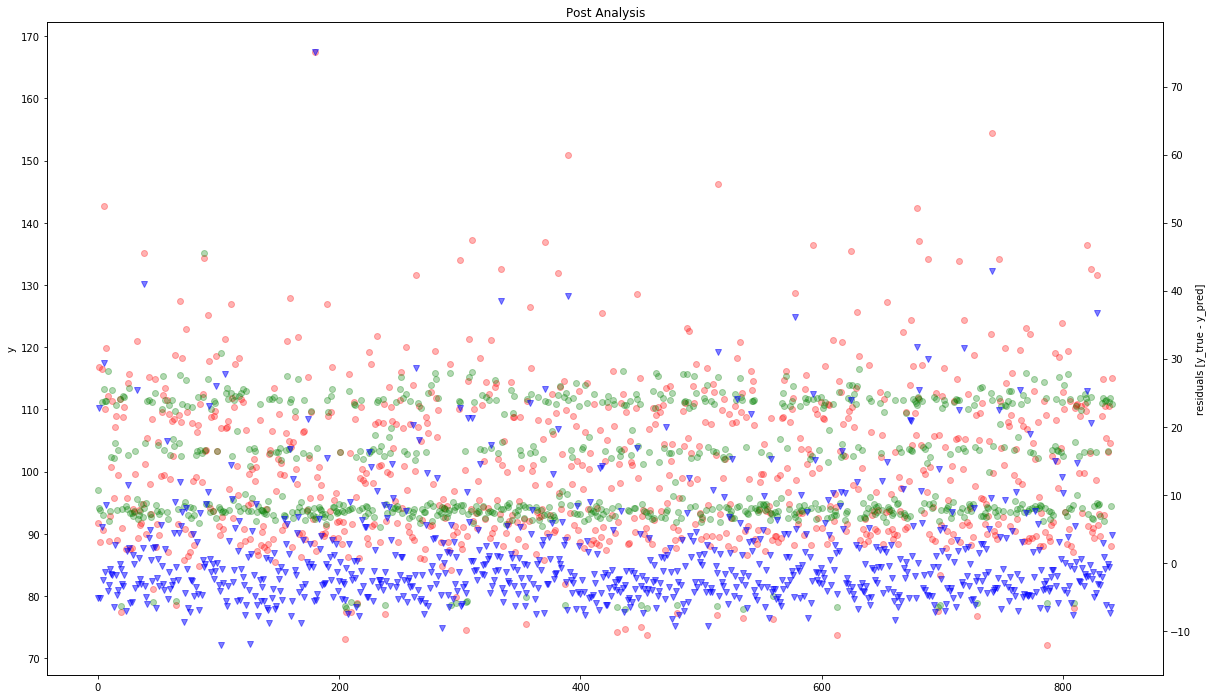

In [21]:
#post_analysis = val_x.copy()
post_analysis = pd.DataFrame()
post_analysis['y_pred'] = holdout_Y_ensembled
post_analysis['y_true'] = holdout_Y
post_analysis['residuals'] = post_analysis[['y_pred', 'y_true']].apply(lambda x: x['y_true'] - x['y_pred'], axis=1)

# graphing code
fig, ax1 = plt.subplots(figsize=(20,12))
ax2 = ax1.twinx()
plt.title('Post Analysis')
ax1.set_ylabel('y')
ax2.set_ylabel('residuals [y_true - y_pred]')
plt.xlabel('user_id')
ax1.plot(post_analysis.index.values, post_analysis['y_true'],'ro', alpha=0.30)
ax1.plot(post_analysis.index.values, post_analysis['y_pred'],'go', alpha=0.30)
ax2.plot(post_analysis.index.values, post_analysis['residuals'],'bv', alpha=0.50)
#ax1.plot(range(len(stacked_Y)), stacked_Y,'yo', alpha=0.30)

ax1.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(10))
plt.show()

In [22]:
# Create submission file
submission_df = test_df[['ID']]
submission_df['y'] = test_Y_ensemble_1.tolist()
submission_df.to_csv(os.path.join(SUBMISSION_PATH, 'submission-' + str(int(time.time())) + '.csv'), index=False)
print('Generated submission ', os.path.join(SUBMISSION_PATH, 'submission-' + str(int(time.time())) + '.csv'))

Generated submission  /kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions/submission-1498276155.csv


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
